<a href="https://colab.research.google.com/github/VincentCCL/MTAT/blob/main/notebooks/MTAT26_RNN_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#4.3  RNN Language Model Toy Example

Modern AI systems, such as large language models (LLMs), are extremely complex and trained on enormous datasets. However, their core behaviour still follows the same simple principle: *Generate the next word based on previous words.*

By building a small neural language model ourselves, using only a few lines of Python and a tiny dataset, we can clearly see:
* how text is converted into numbers;
* how a recurrent neural network processes a sentence from left to right;
* how the model learns to prefer some continuations over others;
* how the system generates text word by word.

These concepts carry directly over to neural machine translation, where the decoder predicts
each target word in exactly the same incremental way.

We build a small but complete word-level recurrent neural language model (RNN-
LM) using Keras. The design mirrors the preprocessing pipeline used for a simple RNN-based NMT system:
* we work at the word level;
* we add <sos> and <eos> markers;
* we use Tokenizer from keras.preprocessing;
* we pad sequences and use mask_zero=True in the embedding;
* we train an RNN to predict the next word at each time step.

As a running example we will track the sentence:
`she likes apples` through all preprocessing steps

## Import modules

We need to import the necessary modules.

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

##4.3.1 Step 1: The toy corpus

We start from a tiny toy corpus that combines simple copula sentences with a few `likes apples` sentences:


In [3]:
src_raw = [
    "i am a student",
    "i am a teacher",
    "you are a student",
    "you are a teacher",
    "she is a student",
    "he is a teacher",
    "we are students",
    "they are teachers",
    "i like apples",
    "you like apples",
    "she likes apples",
    "he likes apples",
]


On its own, this corpus is much too small for any serious language modelling, but it is ideal for
illustrating all steps transparently.

##4.3.2 Step 2: Add `<sos>` and `<eos>` to each sentence

Neural sequence models usually operate on sequences that are explicitly marked for their beginning and end. We therefore prepend `<sos>`  (start-of-sentence) and append `<eos>` (end-of-sentence) to every sentence:

In [4]:
src = [f"<sos> {s} <eos>" for s in src_raw]

For the running example, this yields:

`"she likes apples" −→ "<sos> she likes apples <eos>".`

Including these markers in the tokenisation step ensures they become regular tokens with their own indices in the vocabulary.

In [5]:
src

['<sos> i am a student <eos>',
 '<sos> i am a teacher <eos>',
 '<sos> you are a student <eos>',
 '<sos> you are a teacher <eos>',
 '<sos> she is a student <eos>',
 '<sos> he is a teacher <eos>',
 '<sos> we are students <eos>',
 '<sos> they are teachers <eos>',
 '<sos> i like apples <eos>',
 '<sos> you like apples <eos>',
 '<sos> she likes apples <eos>',
 '<sos> he likes apples <eos>']

---

##4.3.3 Step 3: Tokenisation and Vocabulary

We now build a word-level vocabulary using Keras' Tokenizer. We disable the default filters so that no punctuation or special tokens (like `<sos>` and `<eos>`) are removed.

We also set all tokens to lowercase, setting the `lower` argument to `True`.


In [6]:
tokenizer_src = Tokenizer(filters='', lower=True)
tokenizer_src.fit_on_texts(src)


This is the step where the Tokenizer reads the entire corpus and builds the vocabulary. More
precisely, it:
1. splits all sentences into lowercased individual words;
2. collects every unique word that appears anywhere in the corpus;
3. counts word frequencies;
4. assigns an integer ID to each word (the most frequent word receives ID 1);
5. stores dictionary internally: `word_index`: maps words to their integer IDs.

After this step, the tokenizer "knows" how to convert any sentence made of known words into a sequence of integers.

We can store the mapping in src_word_index:

In [7]:
src_word_index=tokenizer_src.word_index


In [8]:
src_word_index

{'<sos>': 1,
 '<eos>': 2,
 'a': 3,
 'are': 4,
 'apples': 5,
 'i': 6,
 'student': 7,
 'teacher': 8,
 'you': 9,
 'am': 10,
 'she': 11,
 'is': 12,
 'he': 13,
 'like': 14,
 'likes': 15,
 'we': 16,
 'students': 17,
 'they': 18,
 'teachers': 19}



So converting out example sentence:

`<sos> she likes apples <eos>` → `[1, 11, 15, 5, 2]`


Now we convert all our sentences

In [9]:
src_sequences = tokenizer_src.texts_to_sequences(src)

In [10]:
src_sequences

[[1, 6, 10, 3, 7, 2],
 [1, 6, 10, 3, 8, 2],
 [1, 9, 4, 3, 7, 2],
 [1, 9, 4, 3, 8, 2],
 [1, 11, 12, 3, 7, 2],
 [1, 13, 12, 3, 8, 2],
 [1, 16, 4, 17, 2],
 [1, 18, 4, 19, 2],
 [1, 6, 14, 5, 2],
 [1, 9, 14, 5, 2],
 [1, 11, 15, 5, 2],
 [1, 13, 15, 5, 2]]

We also need the reverse table, to go from numbers back to words, and get the id numbers of the special tokens.

In [11]:
# id → word mapping (inverse vocabulary)
src_index_word = {idx: word for word, idx in tokenizer_src.word_index.items()}
src_index_word[0] = "<pad>"

sos_id = src_word_index["<sos>"]
eos_id = src_word_index["<eos>"]

## 4.3.4 Step 4: Padding to a Fixed Length

Neural networks process data in *batches*: several examples are grouped together and passed through the model at the same time. This is much faster and more stable than processing one sentence at a time. See section 4.4 for a more elaborate discussion.

However, a batch must be a *rectangular* matrix: every example must have the same number of time steps. Natural sentences do not satisfy this: some sentences have three words, others four or five. After converting words to integer IDs, we obtain sequences of different lengths.

Such "ragged" sequences cannot form a proper matrix, and therefore cannot be processed in parallel. To solve this, we make all sequences the same length by adding padding tokens (value 0) at the end of shorter sentences:

```
[1, 10, 19, 6] −→ [1, 10, 19, 6, 0]
[2, 7, 14] −→ [2, 7, 14, 0, 0]
```


In [12]:
max_src_len = max(len(seq) for seq in src_sequences)

# Pad sequences (post-padding like in many NMT scripts)
src_sequences_padded = pad_sequences(
    src_sequences,
    maxlen=max_src_len,
    padding="post"
)


In [13]:
src_sequences_padded

array([[ 1,  6, 10,  3,  7,  2],
       [ 1,  6, 10,  3,  8,  2],
       [ 1,  9,  4,  3,  7,  2],
       [ 1,  9,  4,  3,  8,  2],
       [ 1, 11, 12,  3,  7,  2],
       [ 1, 13, 12,  3,  8,  2],
       [ 1, 16,  4, 17,  2,  0],
       [ 1, 18,  4, 19,  2,  0],
       [ 1,  6, 14,  5,  2,  0],
       [ 1,  9, 14,  5,  2,  0],
       [ 1, 11, 15,  5,  2,  0],
       [ 1, 13, 15,  5,  2,  0]], dtype=int32)

## 4.3.5 Step : Building Input and Target Sequences

A language model learns to predict the next word given the previous context. For each padded sentence we create:
* an input sequence X containing all tokens except the last;
* a target sequence Y (what the model has to learn to predict) containing all tokens except the first.

Formally, for each sentence:

$
X = [w_0, w_1, \dots, w_{T-2}], \qquad
Y = [w_1, w_2, \dots, w_{T-1}].\
$

In code:



In [14]:
X_lm = src_sequences_padded[:, :-1]   # drop last token
y_lm = src_sequences_padded[:, 1:]    # drop first token
context_len = X_lm.shape[1]   # e.g. 5
num_src_tokens = len(tokenizer_src.word_index) + 1  # +1 for padding token 0




In [15]:
X_lm

array([[ 1,  6, 10,  3,  7],
       [ 1,  6, 10,  3,  8],
       [ 1,  9,  4,  3,  7],
       [ 1,  9,  4,  3,  8],
       [ 1, 11, 12,  3,  7],
       [ 1, 13, 12,  3,  8],
       [ 1, 16,  4, 17,  2],
       [ 1, 18,  4, 19,  2],
       [ 1,  6, 14,  5,  2],
       [ 1,  9, 14,  5,  2],
       [ 1, 11, 15,  5,  2],
       [ 1, 13, 15,  5,  2]], dtype=int32)

In [16]:
y_lm

array([[ 6, 10,  3,  7,  2],
       [ 6, 10,  3,  8,  2],
       [ 9,  4,  3,  7,  2],
       [ 9,  4,  3,  8,  2],
       [11, 12,  3,  7,  2],
       [13, 12,  3,  8,  2],
       [16,  4, 17,  2,  0],
       [18,  4, 19,  2,  0],
       [ 6, 14,  5,  2,  0],
       [ 9, 14,  5,  2,  0],
       [11, 15,  5,  2,  0],
       [13, 15,  5,  2,  0]], dtype=int32)

At each position in a sentence, the model tries to guess which word is likely to come next:

|Input sequence seen so far |Likely next word(s)|
|---------------------------|--------------------
|&lt;sos&gt;                     |she, i, you, . . .|
|&lt;sos&gt; she                  |likes, is         |
|&lt;sos&gt; she likes            |apples            |
|&lt;sos&gt; she likes apples     |&lt;eos&gt;             |



In short, the language model gradually learns to guess the next word based on the words it has seen so far. This is visualized in

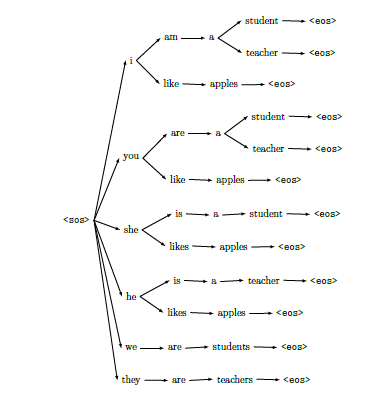

### Teacher Forcing in the Language Model
The way we train our language model uses teacher forcing. By shifting each sentence to create:

$X = [w_0, w_1, \dots, w_{T-1}], \qquad
Y = [w_1, w_2, \dots, w_T],
$
the model always sees the correct previous word and learns to predict the next one. At no point does it use its own predictions as input during training.
This is the same mechanism we will use later in the decoder of the NMT model.


## 4.3.6 Step 6: Define the RNN language model

We now define the neural architecture. It consists of


1. **Input layer**

   Shape: `(context_len,)`: a fixed-length sequence of word IDs.

2. **Embedding layer**

   Converts each word ID into a dense vector.
   E.g., `13` (for `"eat"`) might become `[0.1, -0.3, 0.7, ...]`. The dimensionality of this vector (length of the vector) is set in `output_dim`. We also set `mask_zero=True` in the embedding so that padding tokens (index 0) are ignored inside the RNN.

3. **SimpleRNN layer** with `return_sequences=True`

   Processes the sequence step by step, maintaining a **hidden state** that summarizes all previous words. Because `return_sequences=True`, the RNN outputs a hidden state for every time step.

4. **Dense layer with softmax** over the vocabulary

   For every time step, outputs a vector of length `num_src_tokens`, with probabilities for each possible next word.

In words:

> At each position in the sentence, the RNN reads the current word (as an embedding), updates its internal memory, and then the Dense+softmax predicts which word is most likely to come next.

---

In [17]:
embed_dim   = 64
hidden_size = 128
num_src_tokens = len(tokenizer_src.word_index) + 1


inputs = keras.Input(shape=(max_src_len-1,), dtype="int32")

x = layers.Embedding(
    input_dim=num_src_tokens,
    output_dim=embed_dim,
    mask_zero=True           # ignore padding 0, like in a proper seq2seq
)(inputs)

x = layers.SimpleRNN(
    hidden_size,
    return_sequences=True    # predict a word at every time step
)(x)

outputs = layers.Dense(
    num_src_tokens,
    activation="softmax"
)(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",   # y are integer ids
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 5, 64)     │      1,280 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 5)         │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn          │ (None, 5, 128)    │     24,704 │ embedding[0][0],  │
│ (SimpleRNN)         │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5, 20)     │      2,580 │ simple_rnn[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,564 (111.58 KB)

 Trainable params: 28,564 (111.58 KB)

 Non-trainable params: 0 (0.00 B)

Conceptually, the model processes a sentence one word at a time, from left to right:
* At each position it looks at two things:
  * the current word (in its embedded, vector form), and
  * its internal memory of everything it has seen so far (the *hidden state*).
* It combines these to update its hidden state: this is the models evolving *representation* of the sentence prefix.
* A final layer then turns this hidden state into a set of scores for all words in the vocabulary.
* After applying a softmax, these scores become something like “preferences” or probabilities for each possible next word.

In more informal terms: at each step the RNN reads the next word, updates its memory of the sentence so far, and then asks:
> *Given everything I have seen up to this point, which word would most naturally come next?*




We can visualize the model

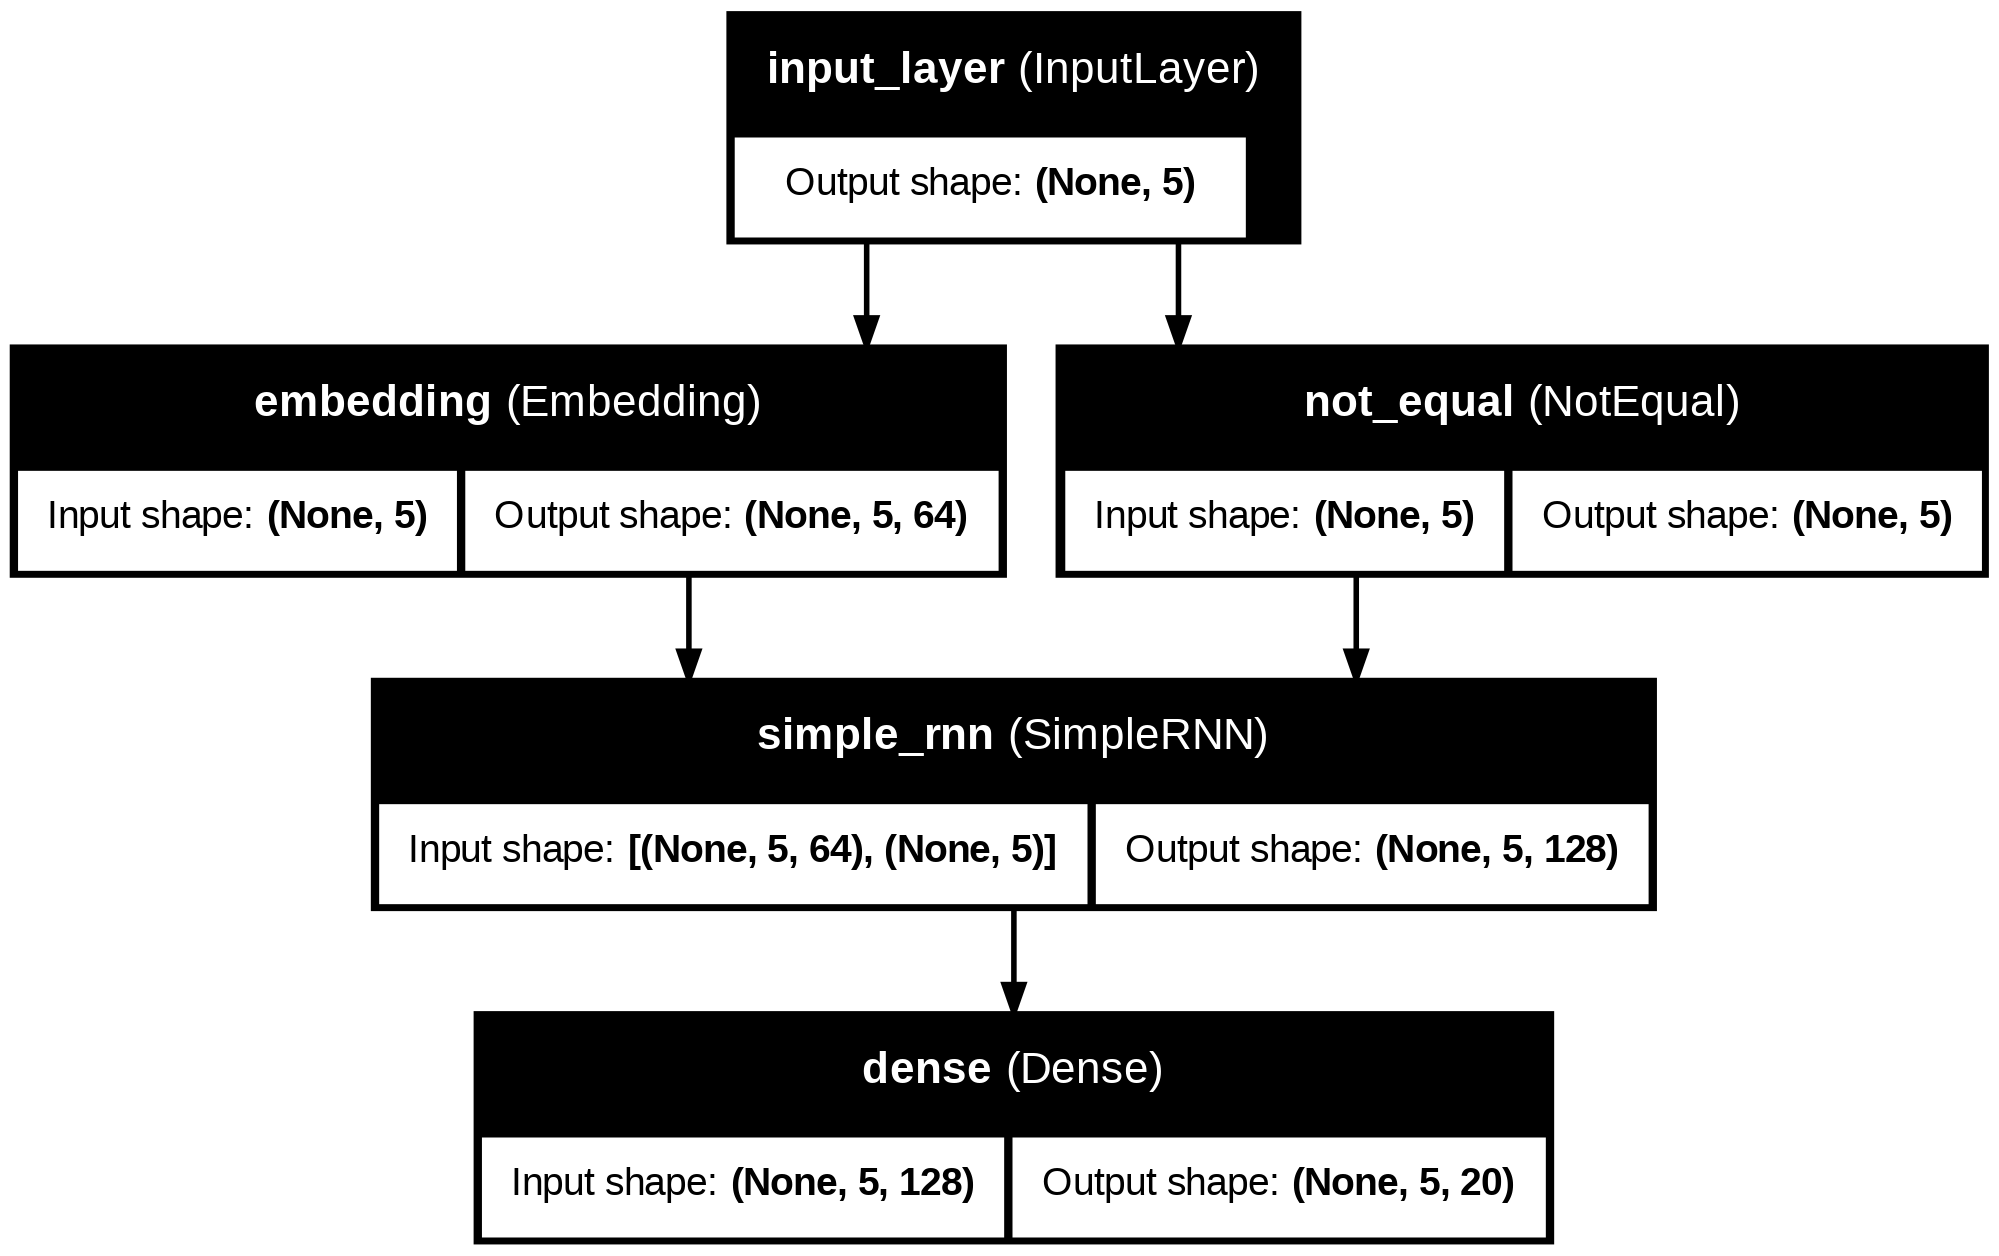

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
)


### Understanding the Keras Model Diagram
The diagram generated by Keras shows the structure of our recurrent language model. Each box represents a layer, and each arrow shows how data flows from one layer to the next during processing. Below we explain each component in turn.

**Input layer** The input layer receives a batch of sentences, where each sentence is a sequence of five integer token IDs. The shape `(None, 5)` indicates that the batch size is flexible `(None)`, and each sentence always has length 5 after padding.

**Embedding layer** The embedding layer converts each integer token into a dense 64-dimensional vector. After this layer, the model no longer works with word IDs but with continuous numerical representations. The output shape `(None, 5, 64)` means: for each of the 5 positions, we now have a 64-element embedding vector.

**Masking** `(NotEqual)` **layer** This layer appears automatically because we used `mask_zero=True`in the embedding. Its only purpose is to detect which positions in the input are padding tokens (value 0). It outputs a boolean mask such as:

`[1, 10, 19, 18, 6] → [True, True, True, True, True]`, and

`[1, 10, 19, 18, 0] → [True, True, True, True, False]`.

The RNN uses this mask to avoid updating its state on padded positions.

**SimpleRNN layer** The recurrent layer processes the sentence one word at a time. At each position, it reads the corresponding embedding vector and updates its hidden state (size 128). Because we set `return_sequences=True`, the layer produces one output vector per time step, giving the output shape `(None, 5, 128)`. The RNN also receives the mask from the previous layer so that it can ignore padding.

**Dense (output) layer**  The dense layer converts each RNN output vector into a score for every word in the vocabulary (here, 20 words including `<sos>` and `<eos>`). The resulting shape `(None, 5, 20)` means that the model predicts a distribution over the 20 vocabulary items at each of the 5 positions. After the softmax (applied inside the loss function), these scores become the model's guesses for the next word.

The diagram visualises the flow:

> token IDs → embeddings → RNN → vocabulary predictions,

with masking handled automatically. This is the complete computation performed by our simple recurrent language model

##4.3.7 Step 7: Train the model

We can now train the model by providing `X_lm` as input and `y_lm` as the expected output. The loss is computed at each time step.
The goal is to (automatically) adjust weights so that the predicted next word matches the true next word as often as possible.

We call:

```python
model.fit(X_lm, y_lm, ...)
```

* `X_lm` is shape `(num_sentences, context_len)`
* `y_lm` is shape `(num_sentences, context_len)`

At each time step, the loss compares:

* Predicted distribution over words
* True next word ID from `y_lm`

Over many epochs, the model learns patterns like:

* After `<sos> you are a` → `student` or `teacher
* After ``she` → `is` or `likes`
* After a content word like `apples` at the end of a sentence → `<eos>`



In [19]:
# ----------------------------------------------------
# 7. TRAIN
# ----------------------------------------------------
# y_lm has shape (batch, time); sparse CE works on that directly.
history = model.fit(
    X_lm, y_lm,
    batch_size=16,
    epochs=10,
    verbose=1
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1000 - loss: 2.9869
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5167 - loss: 2.5719
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5333 - loss: 1.8940
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4167 - loss: 1.7068
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4000 - loss: 1.4488
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5667 - loss: 1.2752
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6000 - loss: 1.0643
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6333 - loss: 0.9700
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5833 - loss: 0.9504
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6500 - loss: 0.8869


##4.3.8 Step 8: Generate text (sampling)

We want to use the trained model to produce new sequences, starting from a seed like `she likes`.

1. **Prepare the seed**
   Start with `<sos> she likes`.
   Convert to IDs and, if needed, pad or truncate to length `context_len`.

   Example:

   ```text
   "<sos> she likes"
   → [1, 11, 15]
   → padded/truncated to length 5, e.g. [0, 0, 1, 11, 15]
   ```

2. **Feed into the model**
   Give the whole context sequence to the model.
   The model outputs predictions for each position, but we only look at the **last time step**, corresponding to the last word `likes`.

3. **Sample the next word**
   The last time step gives a probability distribution over the vocabulary:

   ```text
   P(<sos> | context),
   P(they | context),
   P(eat | context),
   P(apples | context),
   P(teacher | context),
   P(<eos> | context),
   ...
   ```

   We **sample** one ID from this distribution (possibly using a temperature parameter to control randomness).

   Suppose it picks `apples`.

4. **Append and repeat**

   * Add `apples` to the sentence.
   * Slide the context window: we now use the last `context_len` tokens as the new input sequence.
   * Ask the model again for the next word (maybe now it predicts `<eos>`).
   * Stop when we hit `<eos>` or when we generated a maximum number of tokens.

So for `she likes"` you might get:

```text
Input seed: "she likes"
Model generates: "she likes apples <eos>"
Final printed sentence: "she likes apples"
```
because we cut off everything after `<eos>` before printing.

We use *temperature* to control randomness: temperatures < 1 make the distribution sharper
(more deterministic), while temperatures > 1 make it flatter (more random).


In [20]:
# ----------------------------------------------------
# 8. GENERATION (ANALOGOUS TO STEP-BY-STEP DECODING)
# ----------------------------------------------------
def sample_next_token(probs, temperature=1.0):
    """Sample a token id from a probability distribution with temperature."""
    probs = np.asarray(probs).astype("float64")
    probs = np.maximum(probs, 1e-8)
    probs = np.log(probs) / temperature
    probs = np.exp(probs)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs)

def generate_from_lm(seed_text, num_steps=10, temperature=0.8):
    """
    seed_text: string without <sos>/<eos>, e.g. "i like"
    num_steps: how many NEW tokens to generate
    """
    # Add <sos> so the model sees a proper start
    full_seed = f"<sos> {seed_text}"
    seed_seq = tokenizer_src.texts_to_sequences([full_seed])[0]

    # Start with at least context_len tokens (left-pad with 0 if needed)
    if len(seed_seq) < context_len:
        seed_seq = [0] * (context_len - len(seed_seq)) + seed_seq
    else:
        seed_seq = seed_seq[-context_len:]

    generated_ids = seed_seq[:]   # we keep the entire sequence of ids

    for _ in range(num_steps):
        # Use the last context_len ids as input
        context = np.array(generated_ids[-context_len:], dtype="int32")[None, :]  # (1, context_len)

        # Model outputs probs for each time step; we only need the LAST one
        preds = model.predict(context, verbose=0)[0]     # (context_len, vocab)
        next_probs = preds[-1]                           # distribution at last step

        next_id = sample_next_token(next_probs, temperature=temperature)
        generated_ids.append(next_id)

        # Stop early if we hit <eos>
        if next_id == eos_id:
          break

    id_to_word = {i: w for w, i in src_word_index.items()}
    id_to_word[0] = "<pad>"

    words = [id_to_word[i] for i in generated_ids if i != 0]

    # Drop initial <sos> in final display
    if words and words[0] == "<sos>":
      words = words[1:]

    # Cut at first <eos> if present
    if "<eos>" in words:
      eos_pos = words.index("<eos>")
      words = words[:eos_pos]  # everything before <eos>

    return " ".join(words)


In [21]:

print(generate_from_lm("she likes", num_steps=5, temperature=0.8))
print(generate_from_lm("i am", num_steps=5, temperature=0.8))

she likes apples
i am apples


###Temperature in Language Model Sampling

When the model generates text, it does not choose the next word deterministically. Instead, at each time step it produces a probability distribution over all possible next words. The *temperature* parameter controls how “confident” or “creative” the model is when sampling from this distribution.

Low temperature (e.g. 0.5) A low temperature makes the distribution sharper: the most likely words become even more likely. The model behaves conservatively and tends to choose safe, predictable continuations. This often leads to more repetitive output.

High temperature (e.g. 1.2) A high temperature makes the distribution flatter: less likely words become more accessible. The model behaves more creatively, occasionally choosing unexpected or unusual continuations. The output can be more varied, but also more error-prone.

Temperature of 1.0 A temperature of 1.0 means “no change” to the model’s internal probabilities. This corresponds to the model’s natural behaviour.

Intuition You can think of temperature as a creativity dial:
* low temperature = safe choices,
* high temperature = more adventurous choices.

# 4.4 A Short Note on Batches

Before we train our language model, we need to understand a practical concept used in almost all neural network training: *batches*. This is not a linguistic idea but a computational one, and we keep the explanation informal.

## 4.4.1 Why not train on one sentence at a time

Neural networks learn by adjusting their internal weights based on errors. If we showed the model only one sentence at a time, learning would be:

* very slow (the network updates after every single example),
* unstable (each tiny example may push the model in a different direction),
* inefficient on modern hardware.


## 4.4.2 Why not train on the whole dataset at once?

If we put all sentences into the model at the same time, learning would be:

* too memory-intensive, as all the sentences would need to be kept in memory,
* slow to update (the model would wait to see \emph{all} data before making a single learning step),
* less flexible (we cannot shuffle or reorder the data as easily).

----

**Batches: the practical compromise**

Instead of using one sentence at a time or the entire dataset, we divide the data into **batches**. A batch is simply a small group of examples that the model processes together.

For example:

`Batch size = 16`: the model processes 16 sentences at once}.


This has several advantages:

* the model can use parallel computation efficiently;
* the training signal becomes more stable than using one example at a time;
* memory usage stays manageable.

**What happens during training?**

Training proceeds in cycles:

1. Take the next batch of sentences (for example, 16 of them).
2. Run them through the model to obtain predictions.
3. Compare the predictions with the correct next words in each sentence.
4. Update the model's weights so that future predictions improve.

When all batches have been processed once, we call this an **epoch**.  
During training, we typically run several epochs.

#4.5 RNN for larger text files

https://colab.research.google.com/drive/1rTZJGbs2SSsDWHmgHXRv5OSfdmePWej1?usp=sharing

